<a href="https://colab.research.google.com/github/cwscx/makmore/blob/main/makemore_part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
words: list[str] = open('names.txt', 'r').read().splitlines()

In [4]:
stoi: dict[str, int] = {c:i for i, c in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos: dict[int, str] = {i:c for c, i in stoi.items()}
vocab_size = len(stoi)

In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 3

def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
  inputs_list: list[list[int]] = []
  labels_list: list[int] = []

  for w in words:
    inputs: list[int] = [0] * block_size
    for c in w + '.':
      index: int = stoi[c]
      inputs_list.append(inputs)
      labels_list.append(index)
      inputs = inputs[1:] + [index]

  return torch.tensor(inputs_list), torch.tensor(labels_list)

threshold1: int = int(0.8 * len(words))
threshold2: int = int(0.9 * len(words))

training_x, training_y = build_dataset(words[:threshold1])
validation_x, validation_y = build_dataset(words[threshold1:threshold2])
test_x, test_y = build_dataset(words[threshold2:])

In [7]:

class Linear:

  def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
    self.weight: torch.Tensor = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
    self.bias: torch.Tensor | None = torch.zeros(fan_out) if bias else None

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out: torch.Tensor = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim: int, eps: float=1e-5, momentum: float=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters.
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    if (self.training):
      x_mean = x.mean(0, keepdim=True)
      x_var = x.var(0, keepdim=True, unbiased=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    standardized_x = (x - x_mean) / torch.sqrt(x_var - self.eps)
    self.out = self.gamma * standardized_x + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out = torch.tanh(x)
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return []

In [8]:
torch.manual_seed(42)

In [9]:
n_embed = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embed))
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    # Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    # Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    # Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [10]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  indexes = torch.randint(0, training_x.shape[0], (batch_size, ))
  batch_x = training_x[indexes]
  batch_y = training_y[indexes]

  embedding = C[batch_x]
  x = embedding.view(embedding.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, batch_y)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < max_steps * 0.75 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


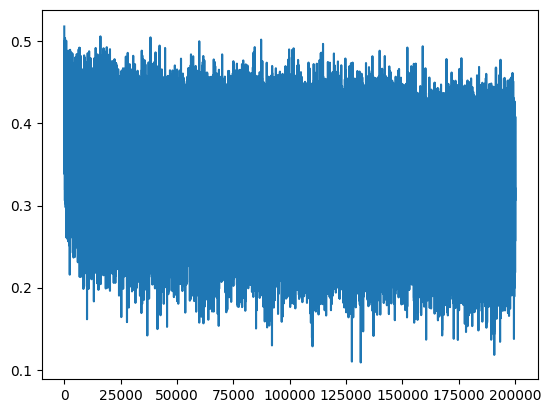

In [11]:
plt.plot(losses)

In [12]:
for layer in layers:
  layer.training = False

In [13]:
@torch.no_grad()
def split_loss(split: str):
  x, y = {
      'train': (training_x, training_y),
      'val': (validation_x, validation_y),
      'test': (test_x, test_y),
  }[split]

  embedding = C[x]
  x = embedding.view(embedding.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0583255290985107
val 2.1065289974212646
test 2.1046242713928223


In [29]:
for _ in range(20):
  input = [0] * block_size
  out = []
  while True:
    emb = C[torch.tensor([input])]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      x = layer(x)
    loss = F.softmax(x, dim=1)
    index = int(torch.multinomial(loss, num_samples=1).item())
    ch = itos[index]
    out.append(ch)
    input = input[1:] + [index]

    if index == 0:
      break
  print(''.join(out))


ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
